# HyperSpy Fitting tutorial

This tutorial shows the basics of model (currently only 1D) fitting in HyperSpy from the grounds up.

__Minimum required version:__ HyperSpy 1.6

## Authors:

- 13/04/2015 Tomas Ostasevicius - Developed for HyperSpy workshop at University of Cambridge
- 01/06/2016 Tomas Ostasevicius - updated and expanded for HyperSpy workshop at Scandem conference 2016
- 22/07/2016 Tomas Ostasevicius - updated for HyperSpy version 1.0
- 19/04/2021 Francisco de la Peña - new synthetic dataset. Add standard deviation discussion.
- 20/04/2021 Francisco de la Peña - Tweak dataset to always fail with `iterpath="flyback"`. Add bounds, fixing parameters and standard deviation check.

<a id='terms'></a>
## Terminology and relationships
<a href='#top'>[back to top]</a> 

In order to use fitting in HyperSpy more effectively, it is useful to understand our structure for curve fitting.

There are three main things, related to fitting:

__1. Model__
can be thought of as a simple box (cooking pot), where we have to put our ingredients. Without anything inside, it is not of much use in this case. Once we add some things to it and mix it a bit (do the actual fitting), however, we have our complete dish!

__2. Component__ is the main building block (ingredient) of our model. Here we mix and match what components we need (or want) for the particular case of signal. 

Examples: 
- Lorentzian (Cauchy)
- Gaussian
- Voigt (a combination of Lorentzian and Gaussian)
- Offset (i.e. constant background)
- Exponential function
- ...
- [create your own or use the very specialised ones!]

Each of the components is ultimately just a function that has variables that change the (shape of the) output. Such a variable in HyperSpy is called a __parameter__. The model is built by combining *linearly* the components.


__3. Parameter__ is the knob that the fitting routine adjusts for a good fit. Each component must include at least one parameter in order to be able to change when fitting. A parameter is also the object that we may limit or have to adjust when the result of the fit is not satisfactory. 

Ultimately, a parameter is the only important thing, as far as the fitting is concerned - components are just smart and convenient boxes to combine parameters into functions, and a model is just a box for a collection of components.

For now, let's just keep the rough structure in our heads and look at other things!



<a id='top'></a>
## Importing and exploring the relevant docstrings

HyperSpy, like all other Python libraries, first has to be imported in your Python setup in order to be used.
Once it is, all the relevant commands can be looped up using the autocompletion feature of the IPython. 

Lets import the HyperSpy and set up plotting.

In [1]:
%matplotlib notebook
import hyperspy.api as hs

Once imported, all the HyperSpy commands are available via the 
> `hs.<something>`

interface. You can also look for the help with any Python object like this
> `help(<something>)`

In [2]:
help(hs)

Help on module hyperspy.api in hyperspy:

NAME
    hyperspy.api - All public packages, functions and classes are available in this module.

DESCRIPTION
    When starting HyperSpy using the ``hyperspy`` script (e.g. by executing
    ``hyperspy`` in a console, using the context menu entries or using the links in
    the ``Start Menu``, the :mod:`~hyperspy.api` package is imported in the user
    namespace as ``hs``, i.e. by executing the following:
    
        >>> import hyperspy.api as hs
    
    
    (Note that code snippets are indicated by three greater-than signs)
    
    We recommend to import the HyperSpy API as above also when doing it manually.
    The docstring examples assume that `hyperspy` has been imported as `hs`,
    numpy as ``np`` and ``matplotlib.pyplot`` as ``plt``. 
    
    Functions:
    
        create_model
            Create a model for curve fitting.
    
        get_configuration_directory_path
            Return the configuration directory path.
    
     

In [3]:
help(hs.model.components1D)

Help on module hyperspy.components1d in hyperspy:

NAME
    hyperspy.components1d - Components that can be used to define a 1D model for e.g. curve fitting.

DESCRIPTION
    There are some components that are only useful for one particular kind of signal
    and therefore their name are preceded by the signal name: eg. eels_cl_edge.
    
    Writing a new template is easy: see the user guide documentation on creating
    components.
    
    For more details see each component docstring.
    Arctan                    This is the legacy Arctan component dedicat..
    Bleasdale                 Bleasdale function component...
    Doniach                    Doniach Sunjic lineshape..
    DoublePowerLaw            Double power law component for EELS spectra..
    EELSArctan                Arctan function component for EELS (with mi..
    EELSCLEdge                EELS core loss ionisation edge from hydroge..
    Erf                       Error function component...
    Exponential          

<a id='loading'></a>
## Loading the data and creating the model
<a href='#top'>[back to top]</a> 

First you should have a spectrum (a particular kind of the `Signal` subclass!) you want to fit. Let's load a synthetic dataset with some curves named 
> `"two_peaks.hspy"`

and have a look at it.

If you can't load the dataset, it means you most likely have not generated it yet. Please run the two cells <a href='#two_peaks'>at the end</a> of the notebook to do so.

In [4]:
s = hs.load("two_peaks.hspy")

In [5]:
s

<Signal1D, title: Two gaussians, dimensions: (32, 32|1024)>

In [6]:
s.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Exploring the dataset we notice that it consists of two peaks that at different points change position and height. In oder to measure the position, height and width of the two peaks at all position we will create a ``Model`` that consists of 2 gaussian functions.

<a id='creating_model'></a>
<a href='#top'>[back to top]</a> 

Creating a model now is simple - just pass the spectrum to the function 
> `model_reference = signal_reference.create_model()`

Let's reference the model by "`m`".

In [7]:
m = s.create_model()

Let's look what's inside:

In [8]:
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------

As we can see, the model is still empty. That will not always be the case - for some types of signals, an automatic background component is added when creating a model, hence it's always good to check.

We can plot the model in exactly the same way as the signal:

The only difference from the model plot is that each data point is displayed individually. 

<a id='creating_components'></a>
<a href='#top'>[back to top]</a> 

To do anything with the model, we should __create__ some __components__ and add them. Let's create two gaussians, referenced as "g1" and "g2":

-----------------
P.S.: keep in mind that creating a component is a function - hence there should be brackets at the end! Such as 
> `our_component_reference = hs.model.components1D.example_component()`

In [9]:
g1 = hs.model.components1D.GaussianHF()
g2 = hs.model.components1D.GaussianHF()

<a id='adding_comps'></a>
<a href='#top'>[back to top]</a> 

... and __add the components to__ our __model__. For that there are generally two ways:

Individually
> `our_model_reference.append(our_component_reference)`

or in lists (i.e. grouped by square brackets)
> `our_model_reference.extend([first_component_reference, second_component_reference])`

In [10]:
m.extend([g1, g2])

Let's check how the model looks now:

In [11]:
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |          GaussianHF |          GaussianHF |          GaussianHF
   1 |        GaussianHF_0 |        GaussianHF_0 |          GaussianHF

<a id='renaming_components'></a>
<a href='#top'>[back to top]</a> 

For our convenience we can __rename__ the __components__ as we choose, for example "wide" and "narrow" (note that the "g1" and "g2" are only references we created for them, not names of the components)

In [12]:
g1.name = "wide"
g2.name = "narrow"

We can look at the model again to see the result

In [13]:
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |                wide |                wide |          GaussianHF
   1 |              narrow |              narrow |          GaussianHF

<a id='checking_values'></a>
<a href='#top'>[back to top]</a>

To finally see the full structure (the one we looked at <a href='#terms'>here</a>), we can __print all of the parameter values__ of all components of the model.

In [14]:
m.print_current_values()

Parameter Name,Free,Value,Std,Min,Max
centre,True,0,,,
fwhm,True,1,,0,
height,True,1,,0,
Parameter Name,Free,Value,Std,Min,Max
centre,True,0,,,
fwhm,True,1,,0,
height,True,1,,0,


To access the values, we have to look inside the components for the parameters. It can simply be done by following the pattern:
> `some_component_reference.parameter_name.value`

In this case the component references are the __g1__ and __g2__, while parameter names are __centre__, __A__ and __sigma__.

At this point it is good practice to store the model so that, if something goes wrong, we can go back to this stage:

In [15]:
m.store(name="new")

In [16]:
m.signal.models

├── ground_truth
│   ├── components
│   │   ├── narrow
│   │   └── wide
│   ├── date = 2021-04-20 12:47:51
│   └── dimensions = (32, 32|1024)
└── new
    ├── components
    │   ├── narrow
    │   └── wide
    ├── date = 2021-04-20 12:48:53
    └── dimensions = (32, 32|1024)

Notice that there is another model stored in the signal, `ground truth`. We'll put it to use at end of this tutorial.

In [17]:
g1.fwhm.value

1.0

Notice that we can access the component more conveniently using its name as follows:

In [18]:
m.components.wide.fwhm.value

1.0

<a id='setting_values'></a>
<a href='#top'>[back to top]</a>

We can __set parameter values__ in exactly the same way. Let set `g1` `sigma` value to 30:

In [19]:
m.components.wide.fwhm.value = 30

In [20]:
m.print_current_values()

Parameter Name,Free,Value,Std,Min,Max
centre,True,0,,,
fwhm,True,30,,0,
height,True,1,,0,
Parameter Name,Free,Value,Std,Min,Max
centre,True,0,,,
fwhm,True,1,,0,
height,True,1,,0,


For convenience, we can also __set values "in bulk"__ for all components in the model. The required command is
> `m.set_parameters_value`

Set the area ("A" parameter) of both peaks to 500

In [21]:
m.set_parameters_value('height', 100)

In [22]:
m.print_current_values()

Parameter Name,Free,Value,Std,Min,Max
centre,True,0,,,
fwhm,True,30,,0,
height,True,100,,0,
Parameter Name,Free,Value,Std,Min,Max
centre,True,0,,,
fwhm,True,1,,0,
height,True,100,,0,


## Indexing the model and fitting a single spectrum

We will start by analyzing the data at one single pixel. For that we can using the same indexing syntax that we use for signals.

In [23]:
m00 = m.inav[0, 0]

In [24]:
m00.plot(plot_components=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In order to increase the chances of obtaining a good fit to the data, we must provide better starting parameters.

We could do that interactively, using ``m.gui()`` or manually as follows:

In [25]:
m00.components.narrow.centre.value = 60
m00.components.wide.centre.value = 50

We are now ready to fit

In [26]:
m00.fit()

   covar: array([[ 1.76830147e-04, -5.11658338e-05,  1.93802041e-04,
        -8.01526059e-06, -8.68573149e-05, -3.93832136e-04],
       [-5.11658338e-05,  1.08993808e-03, -1.49141316e-03,
        -3.06548331e-05,  1.62328408e-04,  7.76505163e-04],
       [ 1.93802041e-04, -1.49141316e-03,  5.07437902e-03,
         5.16094662e-05, -7.30358575e-04, -3.23763439e-03],
       [-8.01526059e-06, -3.06548331e-05,  5.16094662e-05,
         1.21034752e-04, -2.78305323e-06, -1.31480558e-05],
       [-8.68573149e-05,  1.62328408e-04, -7.30358575e-04,
        -2.78305323e-06,  7.92559428e-04, -2.15838794e-03],
       [-3.93832136e-04,  7.76505163e-04, -3.23763439e-03,
        -1.31480558e-05, -2.15838794e-03,  3.62907692e-02]])
     fun: array([-0.28860998, -1.12330872,  1.04291008, ..., -4.09065073,
       -2.22072033, -2.34996863])
 message: 'Both actual and predicted relative reductions in the sum of squares\n  are at most 0.000000'
    nfev: 64
  status: 1
 success: True
       x: array([ 49.08

The fit (notice that the model got updated in the figure) looks good!

Notice that the value of the parameters have changed to their optimal value. Also notice that the standard deviation has been estimated too.

In [27]:
m00.print_current_values()

Parameter Name,Free,Value,Std,Min,Max
centre,True,49.0813,0.125441,,
fwhm,True,59.8721,0.311431,0,
height,True,139.921,0.671974,0,
Parameter Name,Free,Value,Std,Min,Max
centre,True,60.0092,0.103781,,
fwhm,True,5.90457,0.265569,0,
height,True,48.6432,1.79704,0,


But how to know how good is the fit? 


Once the fit was performed, chi-squared ($\chi^2$), degrees of freedom and reduced chi-squared ($\chi^2_\nu$) of the fit are automatically calculated.

They are accessible with, respectively:
> `m2.chisq`

> `m2.dof`

> `m2.red_chisq`

Let's have a look at reduced $\chi^2$ by plotting it

In [28]:
m00.red_chisq.data

array([89.07346101])

That's far too big! (A good fit should have $a\chi^2_\nu$ of around 1.)

The issue is that we haven't defined the variance of the noise:

In [29]:
m00.signal.metadata

├── General
│   └── title = Two gaussians
└── Signal
    ├── binned = False
    └── signal_type =

For that we can use the following ``Signal`` method:

In [30]:
m00.signal.estimate_poissonian_noise_variance()

Let's now fit. Because the noise variance is available, HyperSpy will now perform weighted non-linear least squares automatically.

In [31]:
m00.fit()

   covar: array([[ 1.05592398e-02, -3.91479407e-03,  1.34613574e-02,
        -4.90584075e-04, -5.85925231e-03, -2.25958693e-02],
       [-3.91479407e-03,  5.63446391e-02, -1.23981408e-01,
        -1.92875392e-03,  1.65734689e-02,  6.84912325e-02],
       [ 1.34613574e-02, -1.23981408e-01,  5.62520683e-01,
         5.64066839e-03, -8.52446453e-02, -3.32862216e-01],
       [-4.90584075e-04, -1.92875392e-03,  5.64066839e-03,
         1.82595481e-02, -2.24068762e-03, -1.43013956e-03],
       [-5.85925231e-03,  1.65734689e-02, -8.52446453e-02,
        -2.24068762e-03,  1.11382133e-01, -3.78334532e-01],
       [-2.25958693e-02,  6.84912325e-02, -3.32862216e-01,
        -1.43013956e-03, -3.78334532e-01,  5.85821303e+00]])
     fun: array([-0.18588423, -0.35635426,  0.09923745, ..., -1.06540541,
       -0.68143743, -0.71105147])
 message: 'Both actual and predicted relative reductions in the sum of squares\n  are at most 0.000000'
    nfev: 29
  status: 1
 success: True
       x: array([ 49.00

In [32]:
m00.red_chisq.data

array([1.03117735])

That's much better!

In [33]:
m00.print_current_values()

Parameter Name,Free,Value,Std,Min,Max
centre,True,49.0081,0.104296,,
fwhm,True,59.4605,0.240924,0,
height,True,138.948,0.761242,0,
Parameter Name,Free,Value,Std,Min,Max
centre,True,60.0114,0.137151,,
fwhm,True,5.95489,0.338736,0,
height,True,48.5827,2.45661,0,


Notice that the value of the parameters and their standard deviation has changed. The previous values were biased because we haven't defined the noise variance. These values should be more accurate.

We can obtain an even more accurate result by using the current model to better estimate the noise variance:

In [34]:
m00.signal.estimate_poissonian_noise_variance(expected_value=m00.as_signal())
m00.fit()
m00.print_current_values()

Parameter Name,Free,Value,Std,Min,Max
centre,True,49.06,0.104386,,
fwhm,True,59.9619,0.243351,0,
height,True,139.74,0.764604,0,
Parameter Name,Free,Value,Std,Min,Max
centre,True,59.9998,0.139023,,
fwhm,True,5.98386,0.341362,0,
height,True,48.501,2.45872,0,


In [35]:
m00.red_chisq.data

array([1.04536884])

## Fitting the first line

Let's now analyze the first line before attempting to fit the whole dataset

In [36]:
ml = m.inav[:, 0]

In [37]:
ml.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Notice that the parameters of the first pixels that we have estimated are already set.

Like before, we must estimate the noise variance

In [38]:
ml.signal.estimate_poissonian_noise_variance()

In order to fit the whole line we must use the ``multifit()`` method

In [39]:
ml.multifit()

/home/francisco/Git/hyperspy/hyperspy/model.py:1567: VisibleDeprecationWarning: The 'iterpath' default will change from 'flyback' to 'serpentine' in HyperSpy version 2.0. Change 'iterpath' to other than None to suppress this warning.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

In [40]:
ml.red_chisq.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

That looks pretty good!

Let's have a look at the parameters

In [41]:
ml.components.narrow.height.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Interesting, the height seems to vary between 30 and 120.

In [42]:
ml.components.narrow.centre.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

And the position varies sinusoidally between 40 and 60

In [43]:
ml.components.narrow.fwhm.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

There doesn't seem to be any pattern in the variation of the FWHM, it seems to vary randomly around 6. Let's check if its standard variation to value ratio:

In [44]:
ml.components.narrow.fwhm.as_signal().data.std() / ml.components.narrow.fwhm.as_signal().data.mean()

0.059434453086137186

That's around 5%, which, given the noisiness of the data, is consistent with this  parameter not varying at all,

In [45]:
ml.components.wide.fwhm.as_signal().data.std() / ml.components.wide.fwhm.as_signal().data.mean()

0.005805821949466616

The wide peaks std to value ratio is just .6%, therefore it is reasonable to think that this parameter is fixed too.

More on this later.

## Fitting the whole model

Before fitting, it is a good idea storing the current state of the model. In this way, if we do something wrong, we can always return to this state

In [46]:
s.models

├── ground_truth
│   ├── components
│   │   ├── narrow
│   │   └── wide
│   ├── date = 2021-04-20 12:47:51
│   └── dimensions = (32, 32|1024)
└── new
    ├── components
    │   ├── narrow
    │   └── wide
    ├── date = 2021-04-20 12:48:53
    └── dimensions = (32, 32|1024)

In [47]:
m.store("first line fitted")

In [48]:
m.signal.models

├── first_line_fitted
│   ├── components
│   │   ├── narrow
│   │   └── wide
│   ├── date = 2021-04-20 12:49:48
│   └── dimensions = (32, 32|1024)
├── ground_truth
│   ├── components
│   │   ├── narrow
│   │   └── wide
│   ├── date = 2021-04-20 12:47:51
│   └── dimensions = (32, 32|1024)
└── new
    ├── components
    │   ├── narrow
    │   └── wide
    ├── date = 2021-04-20 12:48:53
    └── dimensions = (32, 32|1024)

In [49]:
m.signal.estimate_poissonian_noise_variance()

In [50]:
m.multifit()

/home/francisco/Git/hyperspy/hyperspy/model.py:1567: VisibleDeprecationWarning: The 'iterpath' default will change from 'flyback' to 'serpentine' in HyperSpy version 2.0. Change 'iterpath' to other than None to suppress this warning.
  warnings.warn(


  0%|          | 0/1024 [00:00<?, ?it/s]

All of those warnings suggest that something has indeed gone wrong.

In [51]:
m.red_chisq.get_histogram().plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

The large number of pixels with a high $\chi_{\nu}^2$ indicates that something is wrong with the fit

In [52]:
m.red_chisq.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

It looks like something went wrong when jumping from the first line to the second, probably because the starting parameters copied from the last pixel of the first row do are not suitable for the first pixel of the second row. Let's restore the model and try fitting with a differing starting parameters strategy:

In [53]:
m = m.signal.models.restore("first line fitted")

In [54]:
m.multifit(iterpath="serpentine")

  0%|          | 0/1024 [00:00<?, ?it/s]

In [55]:
m.red_chisq.get_histogram().plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [56]:
m.red_chisq.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

The fact that there is no contrast shows that this time the fit is good at all pixels in the dataset! This is because with `iterpath="serpentine"` the fitting routine advances one row at the end of each row without retourning to the beginning of the line.

Let's visualize the results:

In [57]:
m.plot_results()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Bounds and fixed components

Notice the the FWHM of the narrow component sometimes gets negative. It doesn't actually matter, but it makes plotting and analysis more challenging. To fix this issue we can constrain the FWHM of the gaussian:

In [58]:
m = m.signal.models.restore("first line fitted")
m.components.narrow.fwhm.bmin = 5.5
m.components.narrow.fwhm.bmax = 6.5

In [59]:
m.multifit(bounded=True, iterpath="serpentine")

  0%|          | 0/1024 [00:00<?, ?it/s]

In [67]:
m.red_chisq.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [68]:
m.plot_results()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

It worked: there is no sign reversal in the narrow FWHM plot anymore.

Let's have a look at the histogram of the FWHM parameter of both peaks:

In [69]:
m.components.narrow.fwhm.as_signal().get_histogram().plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [70]:
m.components.wide.fwhm.as_signal().get_histogram().plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

The peaky shape of the histogram suggests that the parameter variation is only due to noise. The asymmetry is typical of the bias induced by approximating the Poisson noise with a gaussian (i.e. using weighted least-squares instead of an unbiased estimator such as maximum likelihood).

Let's fit again using maximum likelihood:

In [71]:
m.multifit(optimizer="Nelder-Mead", loss_function="ML-poisson")

/home/francisco/Git/hyperspy/hyperspy/model.py:1567: VisibleDeprecationWarning: The 'iterpath' default will change from 'flyback' to 'serpentine' in HyperSpy version 2.0. Change 'iterpath' to other than None to suppress this warning.
  warnings.warn(


  0%|          | 0/1024 [00:00<?, ?it/s]

In [72]:
m.components.narrow.fwhm.as_signal().get_histogram().plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [73]:
m.components.wide.fwhm.as_signal().get_histogram().plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Now the peaks are more symmetric, confirming that the biased loss function was the issue. Let's check their mean:

In [74]:
m.components.wide.fwhm.as_signal().data.mean()

59.99490496867593

In [75]:
m.components.narrow.fwhm.as_signal().data.mean()

6.003292092160273

This is very close to the actual values that in this case are 60 and 6. With this insight we can refit the model setting the 

This suggests that it would have been better to fix the FWHM of the peaks, let's try:

In [76]:
m.store("fitted with ML-poisson")

In [82]:
m = m.signal.models.restore("new")

In [83]:
m.components.narrow.fwhm.value = 6
m.components.narrow.fwhm.free = False
m.components.wide.fwhm.value = 60
m.components.wide.fwhm.free = False

In [86]:
m.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [87]:
m.signal.axes_manager.indices = (0, 0)

In [88]:
m.components.narrow.centre.value = 60
m.components.wide.centre.value = 50
m.set_parameters_value("height", 100)

In [89]:
m.fit()

   covar: array([[ 1.02640456e-02,  2.63088576e-03, -6.91533414e-04,
        -3.52215309e-02],
       [ 2.63088576e-03,  2.63399627e-01,  6.00803510e-04,
        -3.59532800e-01],
       [-6.91533414e-04,  6.00803510e-04,  1.74966402e-02,
        -5.05536492e-03],
       [-3.52215309e-02, -3.59532800e-01, -5.05536492e-03,
         4.24491308e+00]])
     fun: array([-0.05770752, -0.23067977,  0.23108691, ..., -0.96631802,
       -0.57732898, -0.60728395])
 message: 'Both actual and predicted relative reductions in the sum of squares\n  are at most 0.000000'
    nfev: 21
  status: 1
 success: True
       x: array([ 48.97472644, 137.8158598 ,  59.99396502,  49.66752157])

In [90]:
m.multifit(iterpath="serpentine")

  0%|          | 0/1024 [00:00<?, ?it/s]

In [91]:
m.red_chisq.get_histogram().plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Standard deviation

We can also insptect the standard deviation maps:

In [92]:
narrow_centre_value = m.components.narrow.centre.as_signal()
narrow_centre_std = m.components.narrow.centre.as_signal(field="std")

In [93]:
hs.plot.plot_images([narrow_centre_value, narrow_centre_std], label=["centre", "centre std"], axes_decor="off")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[<AxesSubplot:title={'center':'centre'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>,
 <AxesSubplot:title={'center':'centre std'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>]

Notice how the standard deviation image has a contrast? Is that expected? If yes, what should it be correlated with?

Let's now verify that the standard deviation estimation is correct. We know that, if correct, 66% percent of the residuals must fall between a 1 standard deviation interval. Let's use this property to verify the result:

The ground truth is actually stored in the signal:


In [94]:
m.signal.models

├── first_line_fitted
│   ├── components
│   │   ├── narrow
│   │   └── wide
│   ├── date = 2021-04-20 12:49:48
│   └── dimensions = (32, 32|1024)
├── fitted_with_MLpoisson
│   ├── components
│   │   ├── narrow
│   │   └── wide
│   ├── date = 2021-04-20 13:00:09
│   └── dimensions = (32, 32|1024)
├── ground_truth
│   ├── components
│   │   ├── narrow
│   │   └── wide
│   ├── date = 2021-04-20 12:47:51
│   └── dimensions = (32, 32|1024)
└── new
    ├── components
    │   ├── narrow
    │   └── wide
    ├── date = 2021-04-20 12:48:53
    └── dimensions = (32, 32|1024)

In [97]:
narrow_centre_gt = m.signal.models.restore("ground truth").components.narrow.centre.as_signal()

In [98]:
residuals = (narrow_centre_gt - narrow_centre_value).data

In [99]:
residuals_in_1sigma = len(residuals[(residuals > -narrow_centre_std.data) & (residuals < narrow_centre_std.data)])

In [100]:
import numpy as np
100 * residuals_in_1sigma / np.prod(residuals.shape)

68.9453125

That is very close to 66% percent, so it works!

## Appendix I: User define components interesting components

Lets say we have a slightly stranger signal that we want to fit, like this one:

In [33]:
s = hs.load('wobbly_peak.hspy')

<IPython.core.display.Javascript object>


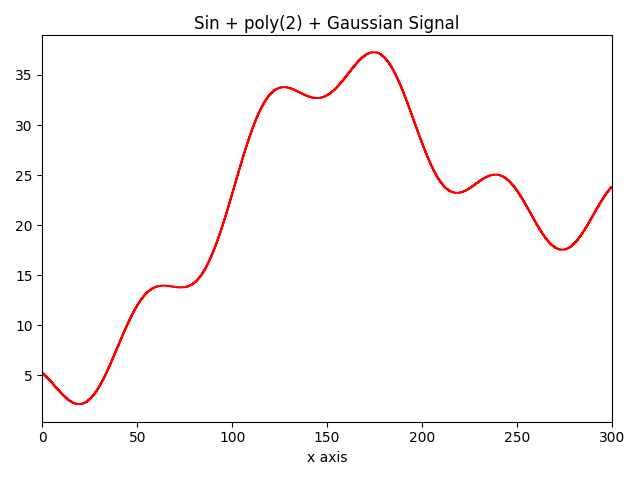

In [34]:
s.plot()

It's (as the name implies) composed of a sinus + gaussian + 2nd degree polynomial. However we don't have a `sin` component in the in-build library, so we'll just write our own:

In [35]:
sin = hs.model.components1D.Expression('A*sin(b*x + c)',
                                        name='sin',)

Then just create and add all the additional components we might need: a gaussian and a polynomial

In [36]:
m = s.create_model()
gaus = hs.model.components1D.Gaussian()
poly = hs.model.components1D.Polynomial(2)
m.extend([sin, gaus, poly])

In [37]:
m.print_current_values()

Components	Parameter	Value
sin
		A	0
		b	0
		c	0
Gaussian
		A	1
		centre	0
		sigma	1
Polynomial
		coefficients[0]	0
		coefficients[1]	0
		coefficients[2]	0


The initial values do not seem to be very useful, so let's just plot the model, turn on the widgets, and we'll play until things seem close enough:

<IPython.core.display.Javascript object>


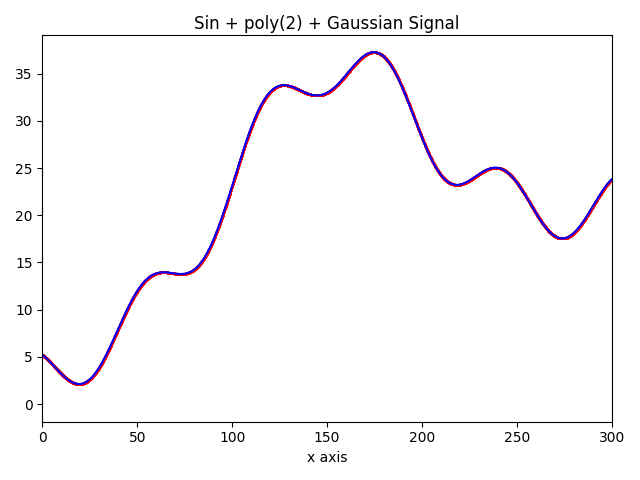

In [38]:
m.plot()

m.gui()

And then fit it and look at the results!

In [39]:
m.fit()

In [40]:
m.print_current_values()

Components	Parameter	Value
sin
		A	-3
		b	0.100033
		c	-0.707963
Gaussian
		A	2999
		centre	149.95
		sigma	49.9833
Polynomial
		coefficients[0]	-2.19049e-11
		coefficients[1]	0.06002
		coefficients[2]	3


## Appendix II: Generating the synthetic data

<a id='two_peaks'></a>
### Two peaks
<a href='#top'>[back to top]</a> 


In [70]:
import numpy as np
import hyperspy.api as hs

domain = 32 #size of the square domain
hfactor = 600
cent = (domain//2, domain//2)
y,x = np.ogrid[-cent[0]:domain-cent[0], -cent[1]:domain-cent[1]]

def gaussian2d(x, y, A=1, x0=0, y0=0, sigmax=20, sigmay=10):
    return A * np.exp(-((x-x0)**2 / 2 / sigmax ** 2 + (y-y0)**2 / 2 / sigmay ** 2))

center_narrow = 50 + 10 * np.sin(3 * np.pi * x / domain) * np.cos(4 * np.pi * y / domain)
center_wide = 50 + 10 * (-0.1 * np.sin(3 * np.pi * x / domain) * np.cos(4 * np.pi * y / domain))

r = np.sqrt(x**2 + y**2)
h_narrow = .5 * (.5 + np.sin(r)**2) * gaussian2d(x, y) *  hfactor
h_wide = (.5 + np.cos(r)**2) * gaussian2d(x, y) *  hfactor

s = hs.signals.Signal1D(np.ones((domain,domain, 1024)))
s.metadata.General.title = 'Two gaussians'
s.axes_manager[0].name = "x"
s.axes_manager[0].units = "nm"
s.axes_manager[1].name = "y"
s.axes_manager[1].units = "nm"

s.axes_manager[2].name = "Energy"
s.axes_manager[2].name = "eV"
s.axes_manager[2].scale = 0.1
m0 = s.create_model()

gs01 = hs.model.components1D.GaussianHF()
gs01.name = "wide"
m0.append(gs01)
gs01.fwhm.value = 60
gs01.centre.map['values'][:] = center_wide
gs01.centre.map['is_set'][:] = True
gs01.height.map['values'][:] = h_wide
gs01.height.map['is_set'][:] = True

gs02 = hs.model.components1D.GaussianHF()
gs02.name = "narrow"
m0.append(gs02)
gs02.fwhm.value = 6
gs02.centre.map['values'][:] = center_narrow
gs02.centre.map['is_set'][:] = True
gs02.height.map['values'][:] = h_narrow
gs02.height.map['is_set'][:] = True
s.data = m0.as_signal().data
s.add_poissonian_noise(random_state=0)
m0.store("ground truth")
s.save("two_peaks.hspy", overwrite=True)

  0%|          | 0/1024 [00:00<?, ?it/s]

<a id='wobbly_peak'></a>
### Wobbly peak
<a href='#top'>[back to top]</a> 


In [7]:
import numpy as np
import hyperspy.api as hs

k = 1
alpha = 15
amp = 3

gaus_position = 15
gaus_width = 5
gaus_A = 300

gradient = 0.6
offset= 3

sin_component = hs.model.components1D.Expression('A * sin(k*x + alpha)', name='sin', k=k,
                                               alpha=alpha, A=amp)
gaus = hs.model.components1D.Gaussian(A=gaus_A, sigma=gaus_width, centre=gaus_position)

poly = hs.model.components1D.Polynomial(1)

poly.coefficients.value = (gradient, offset)

axis = np.linspace(0, 30, 3000, dtype='double')

result = sin_component.function(axis)+ gaus.function(axis) + poly.function(axis)
s = hs.signals.Signal1D(result)
s.axes_manager[0].name = 'x'
s.axes_manager[0].scale = 0.1
s.axes_manager[0].offset = 0

s.metadata.General.author = 'Tomas Ostasevicius'
s.metadata.General.title = 'Sin + poly(2) + Gaussian'
s.save('wobbly_peak', overwrite=True)